In [1]:
from tdavec import createEllipse, TDAvectorizer, tdavec_core
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import pandas as pd
import numpy as np

Hello from tdavec


Let us create some set of squezzed ellipses:

In [2]:
np.random.seed(42)
epsList = np.random.uniform(low = 0, high = 1, size = 500)
np.savetxt("../R/epsList.csv", epsList)
clouds = [createEllipse(a=1, b=eps, n=100) for eps in epsList]

Here are some examples:

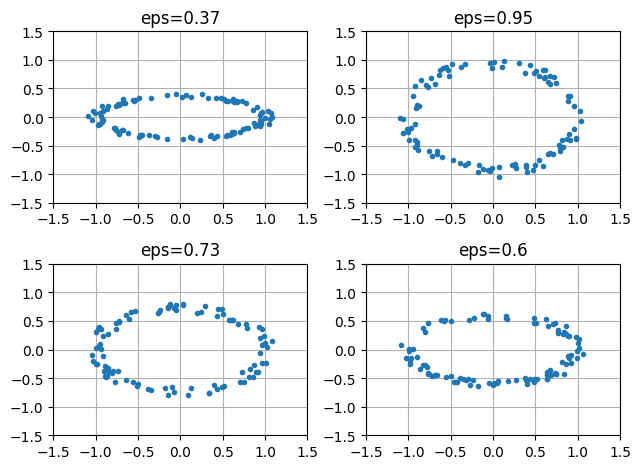

In [3]:
for i, cl in enumerate(clouds[:4]):
    plt.subplot(2, 2, i+1)
    plt.plot(cl[:,0], cl[:,1], ".")
    plt.xlim(-1.5, 1.5); plt.ylim(-1.5, 1.5)
    plt.title(f"eps={np.round(epsList[i], 2)}")
    plt.grid()
plt.tight_layout()

In [4]:
v = TDAvectorizer()
v.setParams({"scale":np.linspace(0, 2, 10)})
v.fit(clouds)

Here are the examples of the generated persistence diagrams:

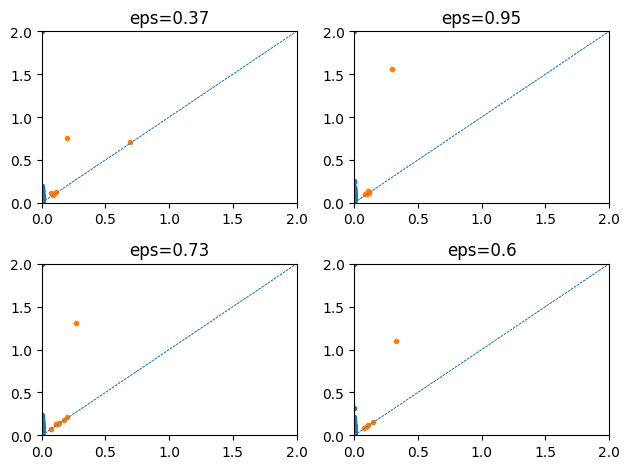

In [5]:
for i in range(4):
    plt.subplot(2,2,i+1)
    PD = v.diags[i]
    for dim in range(2):
        plt.plot(PD[dim][:,0], PD[dim][:,1], ".")
        plt.xlim(0, 2); plt.ylim(0, 2)
        plt.axline( (0,0), slope = 1, linestyle = "--", linewidth = 0.5)
        plt.title(f"eps={np.round(epsList[i], 2)}")
plt.tight_layout()

Here are some PS plots

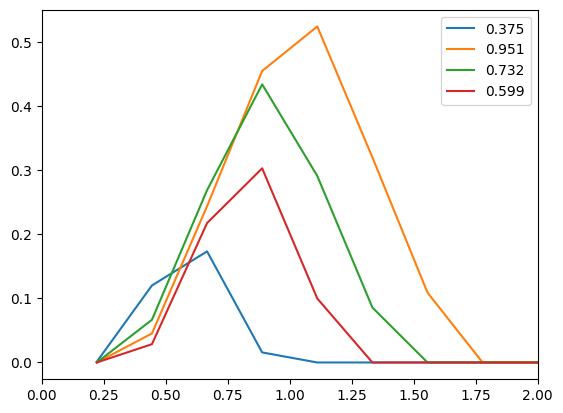

In [6]:
X = v.transform(output="PS", homDim=1)
for i, e in enumerate(epsList[:4]):
    plt.plot(v.getParams()["scale"][1:],X[i,:], label=np.round(e, 3))
    plt.xlim(0, 2)
plt.legend()


Let us now check different vectorization methods

Here is a function that uses specified vectorization method to solve the regression task and guess the squese factor:

In [7]:
v.setParams({"scale":np.linspace(0, 2, 30)})
methodList = v.vectorization_names
def makeSim(method, homDim, vec = v, y=epsList):
    X =v.transform(output=method, homDim=homDim)
    Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, train_size=0.8, random_state=42)
    model = LinearRegression().fit(Xtrain, ytrain)
    test_preds = model.predict(Xtest)
    score = model.score(Xtest, ytest)
    res = {"method":method, "homDim":homDim, "test_preds":test_preds, "y_test":ytest, "score":score}
    return res

Ib the loop below we collect performace statistics for different vectorization methods:

In [8]:
v.transform(output="coord", homDim=0, k=1)

In [13]:
results = []
df = pd.DataFrame()
for homDim in [0, 1]:
    print(f" Dimension {dim}: ", end=" ")
    for method in methodList:
        if method == "stats" or method == "pl":
            continue
        print(method, end = " ")
        res = makeSim(method, homDim); results.append(res)
        df = pd.concat([df, pd.DataFrame(res)])
    print()

 Dimension 1:  vab vpb ps nl ecc pes pi fda algebra poly func coords 
 Dimension 1:  vab vpb ps nl ecc pes pi fda algebra poly func coords 


Here is the regression scores table for different vetcorizations 

In [22]:
df["homDim"] = df["homDim"].astype("category")
comp_df = df[["method", "homDim", "score"]].drop_duplicates().pivot(index="method", columns="homDim", values="score").round(3)
comp_df.sort_values(1, ascending=False)

homDim,0,1
method,,
ecc,0.976,0.996
vab,0.976,0.986
nl,0.960,0.981
poly,0.967,0.975
pi,0.985,0.973
coords,0.966,0.931
ps,0.946,0.914
fda,0.983,0.750
pes,0.989,0.717


In [15]:
comp_df.max()

homDim
0    0.989
1    0.996
dtype: float64

In [29]:
df[df["score"] == df["score"].max()].drop_duplicates()

,method,homDim,test_preds,y_test,score
0,ecc,1,0.665884,0.643288,0.996198
1,ecc,1,0.827094,0.815461,0.996198
2,ecc,1,0.097124,0.071189,0.996198
3,ecc,1,0.238711,0.242055,0.996198
4,ecc,1,0.932745,0.907566,0.996198
...,...,...,...,...,...
95,ecc,1,0.082412,0.045304,0.996198
96,ecc,1,0.732065,0.729606,0.996198
97,ecc,1,0.734124,0.729007,0.996198
98,ecc,1,0.711452,0.706242,0.996198


In [10]:
results = []
df = pd.DataFrame()
for homDim in [0, 1]:
    for method in methodList:
        res = makeSim(method, homDim); results.append(res)
        df = pd.concat([df, pd.DataFrame(res)])
df["homDim"] = df["homDim"].astype("category")
df[["method", "homDim", "score"]].drop_duplicates().\
    pivot(index="method", columns="homDim", values="score").\
    round(3)

homDim,0,1
method,,
ECC,0.976,0.996
FDA,0.983,0.985
NL,0.960,0.981
PS,0.946,0.914
VAB,0.976,0.986


As you can see, they are very close to 1, so fits are pretty accurate

The same can be easily seen from presented below scatter plots whrere for each dimension and method true and predicted values if the ellipse squese factor are shown on horizontal and vertical axes.

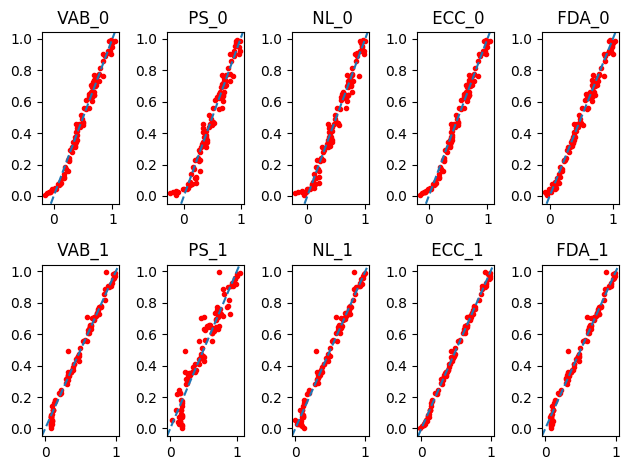

In [11]:
for i, r in enumerate(results):
    plt.subplot(2, 5, i+1)
    plt.plot(r["test_preds"], r["y_test"], "r.")
    plt.axline( (0,0), slope=1, linestyle = "--")
    plt.title(" {}_{}".format(r["method"], r["homDim"]))
plt.tight_layout()